# Clase 4

El objetivo de esta clase es desarrollar el algoritmo de clustering para solucionar un problema de segmentación de clientes, con una población objetivo: consumidores de tarjes de crédito. Se tiene información de 9 mil usuarios sobre su comportamiento con la tarjeta de crédito en los últimos 6 meses.

* Extracción, limpieza y transformación de datos.

* Análisis exploratorio de datos.

* K-means.

Para esta clase se trabajara con los datos de credict card [(Para conocer y descargar acerca de los datos de click aquí)](https://www.kaggle.com/datasets/arjunbhasin2013/ccdata/data)



In [37]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Lectura de datos




In [38]:
df_credit =pd.read_csv("/content/drive/MyDrive/Aprendizaje no supervisado/Base de datos/CC GENERAL.csv" )
df_credit.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [39]:
df_credit.shape # Dimensión de los datos

(8950, 18)

* CUST_ID : Identification of Credit Card holder (Categorical)

* BALANCE : Balance amount left in their account to make purchases

* BALANCE_FREQUENCY : How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)

* PURCHASES : Amount of purchases made from account

* ONEOFF_PURCHASES : Maximum purchase amount done in one-go

* INSTALLMENTS_PURCHASES : Amount of purchase done in installment

* CASH_ADVANCE : Cash in advance given by the user

* PURCHASES_FREQUENCY : How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
ONEOFFPURCHASESFREQUENCY : How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)

* PURCHASESINSTALLMENTSFREQUENCY : How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)

* CASHADVANCEFREQUENCY : How frequently the cash in advance being paid

* CASHADVANCETRX : Number of Transactions made with "Cash in Advanced"

* PURCHASES_TRX : Numbe of purchase transactions made

* CREDIT_LIMIT : Limit of Credit Card for user

* PAYMENTS : Amount of Payment done by user

* MINIMUM_PAYMENTS : Minimum amount of payments made by user

* PRCFULLPAYMENT : Percent of full payment paid by user

* TENURE : Tenure of credit card service for user

In [40]:
df_credit.columns

Index(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE'],
      dtype='object')

Antes de realizar el algoritmo k-means, se debe realizar una limpieza y analisis descriptivo previo.

Lo ideal es realizar una limpieza de datos antes de realizar un analisis descriptivo.

Se cuenta con 18 columnas, una de ellas es un ID del consumidor.



In [41]:
df_credit['CUST_ID'].nunique() # Cuenta la cantidad de valores unicos de una columna

8950

Se observa que se tienen 8950 individuos, no existen datos duplicados. Esto quiere decir que cada registro (fila) representa un consumidor.

La población que se tiene es la información del comportamiento del consumidor en un periodo de 6 meses. Según las columnas que se tienen no contamos con información sobre los consumidores como su edad, género, estado civil, entre otros.

Es importante tenerlo presente tanto para le negocio como el analisis que se realice.


In [42]:
df_credit.isna().sum() # Cantidad de registros faltantes por cada columna

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

Aquí se observa que MINIMUM_PAYMENTS cuenta con 313 registros faltantes, es aquí donde se debe tomar una decisión si dicha variable es importante.

<Axes: xlabel='PAYMENTS', ylabel='MINIMUM_PAYMENTS'>

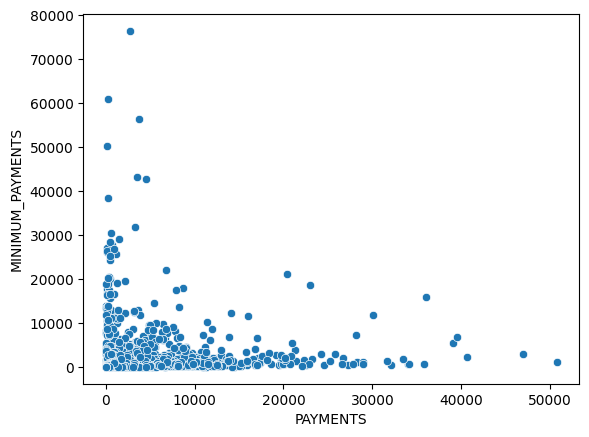

In [43]:
sns.scatterplot( data=df_credit,x="PAYMENTS", y="MINIMUM_PAYMENTS"  )

Se podría pensar que PAYMENTS y MINIMUM_PAYMENTS  deberían ser practicamente similares, sin embargo, visualemente se observa que la relación entre ambas variables no es tan alta.

Por otro lado, este trabajo no incluiremos la variable MINIMUM_PAYMENTS y eliminaremos el individuo que no tiene información sobre CREDIT_LIMIT

In [44]:
df_credit=  df_credit.drop(labels=["MINIMUM_PAYMENTS","CUST_ID"], axis= 1 )
df_credit = df_credit.dropna()

In [45]:
df_credit.shape # Se elimino un usuario para el desarrollo del análisis

(8949, 16)

# Analisis exploratorio

Antes de desarrollar el algoritmo de k-means, importante entender los datos.

In [46]:
df_credit.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000
mean,1564.647593,0.877350,1003.316936,592.503572,411.113579,978.959616,0.490405,0.202480,0.364478,0.135141,3.249078,14.711476,4494.449450,1733.336511,0.153732,11.517935
std,2081.584016,0.236798,2136.727848,1659.968851,904.378205,2097.264344,0.401360,0.298345,0.397451,0.200132,6.824987,24.858552,3638.815725,2895.168146,0.292511,1.337134
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.000000,6.000000
25%,128.365782,0.888889,39.800000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.282850,0.000000,12.000000
50%,873.680279,1.000000,361.490000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,857.062706,0.000000,12.000000
75%,2054.372848,1.000000,1110.170000,577.830000,468.650000,1113.868654,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.279320,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,1.000000,12.000000


Se observqa que la mayoría de las variables cuentan con valores en 0, donde las variables relacionadas con PURCHASES tienen cerca de un 25% de consumidores. ¿Será que un posible grupo pueda ser consumidores que no tienen una alta frecuencia en el uso de su tarjeta de crédito? ¿Se puede proponer estrategias de marketing para este grupo?

# Reto

¿Cuántos consumidores no han utilizado su tarjeta de crédito?


In [33]:
sns.pairplot(df_credit)
plt.show()


Output hidden; open in https://colab.research.google.com to view.

# K-means

Para realizar un algoritmo de k-mens, utilizaremos la librería sklearn.


In [58]:
import sklearn.cluster # Algoritmos de clustering

Antes de realizar el algoritmo de k-means, se deben estandarizar las variables, para esto creamos una nueva variable para los datos estandarizados y no modificar los datos originales.

In [59]:
df_credit_std = df_credit.copy()

for columna in df_credit_std.columns:
  mean_columna = df_credit_std[columna].mean() # La media de la varialbe
  std_columna = df_credit_std[columna].std() # La desviación estandar de la variable
  df_credit_std[columna] = (df_credit_std[columna] -  mean_columna )/std_columna

In [60]:
df_credit_std.describe().round(5)

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
count,8949.00000,8949.00000,8949.00000,8949.00000,8949.00000,8949.00000,8949.00000,8949.00000,8949.00000,8949.00000,8949.00000,8949.00000,8949.00000,8949.00000,8949.00000,8949.00000,8949.00000
mean,0.00000,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000,0.00000,0.00000,0.00000,-0.00000,0.00000,0.00000,0.00000,0.00000,-0.00000,-0.00000,0.00000
std,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
min,-0.75166,-3.70506,-0.46956,-0.35694,-0.45458,-0.46678,-1.22186,-0.67868,-0.91704,-0.67526,-0.47606,-0.59181,-1.22140,-0.59870,-0.52556,-4.12669,-1.94184
25%,-0.68999,0.04873,-0.45093,-0.35694,-0.45458,-0.46678,-1.01423,-0.67868,-0.91704,-0.67526,-0.47606,-0.55158,-0.79544,-0.46631,-0.52556,0.36052,-0.65395
50%,-0.33194,0.51795,-0.30038,-0.33404,-0.35617,-0.46678,0.02391,-0.39936,-0.49770,-0.67526,-0.47606,-0.31021,-0.41070,-0.30267,-0.52556,0.36052,0.63394
75%,0.23527,0.51795,0.05001,-0.00884,0.06362,0.06433,1.06204,0.32687,0.96999,0.43512,0.11003,0.09206,0.55115,0.05801,-0.03718,0.36052,0.63394
max,8.39673,0.51795,22.48122,24.19849,24.42439,22.00879,1.26967,2.67315,1.59899,6.81979,17.54596,13.80968,7.00930,16.92066,2.89312,0.36052,0.63394


¿Cómo podemos utilizar el algoritmo K-means?

Debemos introducir un número de cluster que deseamos inicialmente.

In [61]:
k_means= sklearn.cluster.KMeans(n_clusters = 3) # Activamos el algoritmo para un número de 3 cluster

Luego utilizamos nuestros datos estandarizados para ejecutar el algoritmo.

In [62]:
k_means.fit(df_credit_std ) # Ejectamos el algoritmo en nuestros datos

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3)

Finalmente obtenemos las etiquetas, obtenemos valores de 0, 1 y 2. estos no tienen una descripción, ya que son asignados por similitud.

In [63]:
k_means.labels_ # obtenemos un vector con las etiquetas

array([1, 0, 1, ..., 1, 1, 1], dtype=int32)

Utilizamos los datos originales y asignamos una nueva columna llamada cluster.

In [64]:
df_credit["cluster"]= k_means.labels_
df_credit["cluster"].value_counts()

1    6123
0    1579
2    1247
Name: cluster, dtype: int64

Para el algoritmo seleccionado con 3 cluster, se observa la siguiente distribución, donde los individuos con valores de 2 tienen mayor frecuencia.

Pero ¿esto es lo ideal? ¿Cómo se el número de cluster que tienen mis datos? ¿cómo identifico para los consumidores cuantas posibles estrategias de marketing puedo utilizar?

Uno de los métodos para seleccionar el número de cluster es el método del codo, consiste en gráficar el SSE por valores de k-cluster para determinar el número de cluster idoneo.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

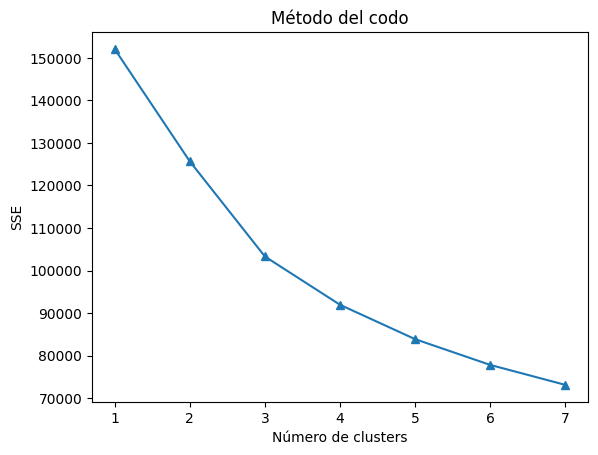

In [79]:
valores_sse = []
numero_cluster= range(1,8 )
# Iterar sobre diferentes valores de k
for k in numero_cluster:
    k_means = sklearn.cluster.KMeans(n_clusters=k)
    k_means.fit(df_credit_std)
    sse=k_means.inertia_
    # Añadir el valor de SSE a la lista
    valores_sse.append(sse)
# Graficar la curva de SSE
plt.plot(numero_cluster, valores_sse,marker='^')
plt.xlabel('Número de clusters')
plt.ylabel('SSE')
plt.title('Método del codo')
plt.show()

In [77]:
import sklearn.metrics

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

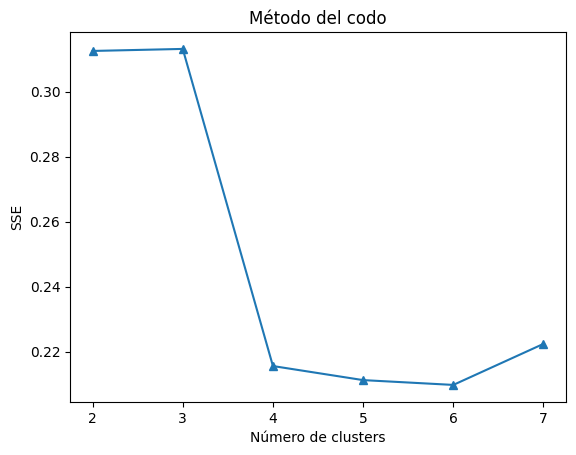

In [85]:
valores_sse = []
numero_cluster= range(2,8 )
# Iterar sobre diferentes valores de k
for k in numero_cluster:
    k_means = sklearn.cluster.KMeans(n_clusters=k)
    k_means.fit(df_credit_std)
    silueta = sklearn.metrics.silhouette_score(df_credit_std, k_means.labels_  )
    # Añadir el valor de SSE a la lista
    valores_sse.append(silueta)
# Graficar la curva de SSE
plt.plot(numero_cluster, valores_sse,marker='^')
plt.xlabel('Número de clusters')
plt.ylabel('SSE')
plt.title('Método del codo')
plt.show()

In [84]:
k_means.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)